# Loading Libraries and Packages

In [9]:
#packages and libraries
import os,sys
from os import listdir
import string
import re
import urllib
import matplotlib.pyplot as plt
import collections
import operator
import pandas as pd
import numpy as np

# Defining MACROS and Environment Variables

In [3]:
#Global Vars and Macros
#_BASE_DIRECTORY = '/Users/007ri/Miniconda2/envs/onedropcs670/Datasets/AoTM'
_BASE_DIRECTORY = '/Users/sidverma/anaconda/Project/AoTM'
_NN = 300
_SPLIT_RATIO = 0.8
dirs = os.listdir(_BASE_DIRECTORY)

filename = 'aotm_list_ids.txt'
currURL = _BASE_DIRECTORY+'/'+filename
response = urllib.urlopen(currURL)
lines = response.readlines()
AOTM_playLists = []
for line in lines:
    AOTM_playLists += line,
print 'Done Loading the AoTM data'
print 'Total Playlist found: ', len(AOTM_playLists)

Done Loading the AoTM data
Total Playlist found:  29164


# This is the pre-processing of AOTM Dataset [..add more later]

In [6]:
#This is the playList class and structure. We will be using this as out playList Object to store and manipulate playlist.
#self._pid : playlist ID
#self._songList : list of tuples of (ArtistID, SongID)
#self._songFreqDict : the frequency table of the songs only in the current playlist
#self._songFreqDictNorm : _songFreqDict in the nomralized form
class playList():
    def __init__(self, inPid, inSongList, inSongDict = {}, inSongNormDict = {}, inTrainList = [], inTestList = []):
        self._pid = inPid # playlist ID
        self._songList = inSongList #list of tuples of (ArtistID, SongID)
        self._songFreqDict = inSongDict
        self._songFreqDictNorm = inSongNormDict
        self._trainList = inTrainList
        self._testList = inTestList
    def __str__(self):
        strObj = 'ID: '+str(self._pid)+'\n'
        for tup in self._songList:
            strObj += str(tup[0]) + ': '
            strObj += str(tup[1]) + '\n'
        return strObj
    def setSongDict(self, inDict):
        self._songFreqDict = inDict
    def setSongDictNorm(self, inNormDict):
        self._songFreqDictNorm = inNormDict
    def setTrainList(self, inTrainList):
        self._trainList = inTrainList
    def setTestList(self, inTestList):
        self._testList = inTestList

##########################################################################################################################
#This is a helper finctions sections. {[rishabh] Please put all your helper functions here for the modularity of the code}
##########################################################################################################################

#genVocab():
#Purpose: to generate the entire vocablulary.
#Input paramas: the input params are the entire dataset which is in the form of list of playList objects.
#Return Value: The return is the set of the unique songs in the entire input data set
def genVocab(inData):
    totalSongsInputSpace = set()
    for pl in inData:
        for tup in pl._songList:
            totalSongsInputSpace.add(tup[1])
    return totalSongsInputSpace

##########################################################################################################################    
#cleanNSerializePlaylist():
#Purpose: to clean, organize and restructure the input playlist which is in string format.
#Input paramas: the input params are the playList in the string format (raw form as read from the aotm dataset).
#Return Value: The return is playList Object of the input playlist
def cleanNSerializePlaylist(inDataEntry):
    ltmp = inDataEntry.split()
    playListID = ltmp[0]
    ltmp.pop(0)
    playListID = re.sub('#', '', playListID)
    n = len(ltmp)
    songList = []
    for i in xrange(0,n-1,2):
        artistid = ltmp[i][:-1]
        songid = ltmp[i+1]
        tup = (artistid,songid)
        songList.append(tup)
    retObj = playList(playListID, songList)
    return retObj

##########################################################################################################################    
#reStructureAOTMDataset():
#Purpose: a wrapper around the cleanNSerializePlaylist() to call it on every playList in the dataset.
#Input paramas: the input params are the entire dataset which is in the form of list of playList as read from the aotm dataset.
#Return Value: The return is list of playList Object.
def reStructureAOTMDataset(inData):
    retVal = []
    allVocab = inData
    for entry in inData:
        retVal.append(cleanNSerializePlaylist(entry))
    return retVal

##########################################################################################################################    
#pidPlObjMapper():
#Purpose: a wrapper around the cleanNSerializePlaylist() to call it on every playList in the dataset.
#Input paramas: the input params is list of playList Object.
#Return Value: The return is a dictionary of pid : playList obj.
def pidPlObjMapper(inData):
    retDict = collections.defaultdict()
    for plObj in inData:
        retDict[plObj._pid] = plObj
    return retDict

##########################################################################################################################    
#AOTM_CleanDataSet :- Contains all playList object of every playlist inthe aotm dataset. Look at the class playList() for details of object structure
#AOTM_All_Songs :- Contains all the songs ever present in the entire aotm dataset
#AOTM_pid_plObj_mapping :- Contains the {pid : playList object} mapping.

AOTM_CleanDataSet = reStructureAOTMDataset(AOTM_playLists)
AOTM_All_Songs = genVocab(AOTM_CleanDataSet)
AOTM_pid_plObj_mapping = pidPlObjMapper(AOTM_CleanDataSet)

print 'Done with processing an parsing the lists. Check stats below: '
print 'Number of Playlists: ', len(AOTM_CleanDataSet)
print 'Total Songs in the AoTM dataset: ', len(AOTM_All_Songs)

Done with processing an parsing the lists. Check stats below: 
Number of Playlists:  29164
Total Songs in the AoTM dataset:  218261


# Exploratory Data Analysis
* Let's look at some of the statistical aspects of our datasets
* We hope to gain some valuable insights which might help our analysis in terms of cleaning the dataset to remove outliers and other spurious features.

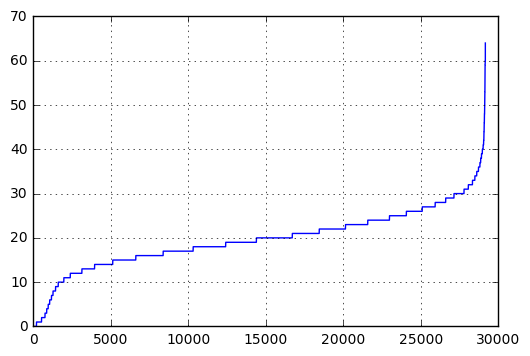

In [8]:
##########################################################################################################################    
#analysisPlaylistSize():
#Purpose: an analysis function to look at the distribution of Playlist Lengths.
#Input paramas: the input params is list of playList Object.
#Return Value: The return is null.

def analysisPlaylistSize(inData):
    X , Y = [], []
    temp = []
    for p in inData:
        temp.append(len(p._songList))
    temp.sort()
    idx = 1
    for t in temp:
        X.append(idx)
        Y.append(t)
        idx += 1
    plt.plot(X, Y)
    plt.grid()
    plt.show()
    return 
analysisPlaylistSize(AOTM_CleanDataSet)

### Key Takeaways:
* As we can see from the above analyses, approx ~ 2000 playlists have a length fewer than 10 songs. Hence it may be difficult to create good recommendations for such user playlists since the vector size is relatively smaller than most of the others in the dataset.
* Thus we propose, to select only those playlists that have a vector length > 10 songs.

In [ ]:
##########################################################################################################################    
#analysisTopTags():
#Purpose: an analysis function to look at the distribution of most Popular Tags.
#Input paramas: the input params is list of playList Object.
#Return Value: The return is null.

# Cleaning Data

In [20]:
##########################################################################################################################    
#removeUnwantedPlaylist():
#Purpose: remove the playLists with less k songs.
#Input paramas: the input params is list of playList Object & k -> thresHold.
#Return Value: list of playList Object with >k songs.
def removeUnwantedPlaylist(inData, k = 10):
    retval = []
    for i in inData:
        if len(i._songList) < 10:
            continue
        retval.append(i)
    return retval

#Clean data
AOTM_CleanDataSet = removeUnwantedPlaylist(AOTM_CleanDataSet, 10)
print "Done removing unwanted playLists, viz pl with <10 songs!"
##########################################################################################################################    
#setTestTrainLists():
#Purpose: a helper to set the plObj._trainList, plObj._testList
#Input paramas: the input params is list of playList Object.
#Return Value: void.
def setTestTrainLists(inData):
    for pl in inData:
        n = len(pl._songList)
        k = int(_SPLIT_RATIO*n)
        trainList = pl._songList[:k]
        testList = pl._songList[k:]
        pl.setTrainList(trainList)
        pl.setTestList(testList)
    return
#invoke fucntion
setTestTrainLists(AOTM_CleanDataSet)
print "Done setting train and test lists!"
##########################################################################################################################    
#setVocabDicts():
#Purpose: a helper to set the plObj.__songFreqDict for each playlist.
#Input paramas: the input params is list of playList Object.
#Return Value: void.
def setVocabDicts(inData):
    for pl in inData:
        plVecDict = collections.defaultdict(int)
        for tup in pl._trainList:
            plVecDict[tup[1]] += 1
        pl.setSongDict(plVecDict)
    return

#invoking the above function call
setVocabDicts(AOTM_CleanDataSet)
print "Done Creating the song freq dicts!"

##########################################################################################################################    
#normalize():
#Purpose: a helper to normalize the plObj._songFreqDict for each playlist.
#Input paramas: the input params is playList._songFreqDict.
#Return Value: the normalized dict of the input playList.
def normalize(inPlaylistDict):
    normSum = 0.0
    retDict = collections.defaultdict()
    for i in inPlaylistDict:
        normSum += inPlaylistDict[i]*inPlaylistDict[i]
    normSum = normSum**0.5
    for i in inPlaylistDict:
        retDict[i] = (1.0*inPlaylistDict[i])/normSum
    return retDict

##########################################################################################################################    
#setNormVocabDicts():
#Purpose: a wrapper to set the plObj._songFreqDictNorm for each playlist.
#Input paramas: the input params is list of playList Object.
#Return Value: void
def setNormVocabDicts(inData):
    for pl in inData:
        SongFreqDictNorm = normalize(pl._songFreqDict)
        pl.setSongDictNorm(SongFreqDictNorm)
    return

#invoking the above function call
setNormVocabDicts(AOTM_CleanDataSet)
print "Done Creating the NORMALIZED song freq dicts!"

Done removing unwanted playLists, viz pl with <10 songs!
Done setting train and test lists!
Done Creating the song freq dicts!
Done Creating the NORMALIZED song freq dicts!


## Cosine Vector Space

In [11]:
##########################################################################################################################    
#getCosineScore():
#Purpose: to calculate the cosine similarity .
#Input paramas: the input params are two playList Objects whose similarity is to be calculated.
#Return Value: cosine similarity measure (float value)
def getCosineScore(inPlaylist, inRefPlayList):
    score = 0.0
    inPlaylistDict = inPlaylist._songFreqDictNorm
    inRefPlayListDict = inRefPlayList._songFreqDictNorm
    for i in inPlaylistDict:
        if i in inRefPlayListDict:
            score += (1.0*inPlaylistDict[i]*inRefPlayListDict[i])
    return score

##########################################################################################################################    
#cosineSimilartiy():
#Purpose: to calculate the cosine similarity .
#Input paramas: the input params is list of playList Object in the entrie input space and the user playlist.
#Return Value: a dict of playList ids as with similarity measure as value.
def cosineSimilartiy(inPlayList, inOtherPlayLists):
    res = collections.defaultdict(float)
    for refPl in inOtherPlayLists:
        if refPl._pid == inPlayList._pid:
            continue
        cosineScore = getCosineScore(inPlayList, refPl)
        res[refPl._pid] = cosineScore
    return res

##########################################################################################################################    
#getKNN():
#Purpose: get k nearest neighbors to inPut playlist.(Distance sim)
#Input paramas: the input params is user playList, list of playList Object and inK which is defaulted to _NN (macro defined at the beginng).
#Return Value: top inK number of playlist IDs as a list.
def getKNN(inPlayList, inOtherPlayLists, bTruncateZeros = False, inK = _NN):#_NN is a macro define above with value 300 or less if we have <300 similars.
    simlarityDict = cosineSimilartiy(inPlayList, inOtherPlayLists)
    sorted_simlarityDict = sorted(simlarityDict.items(), key=operator.itemgetter(1), reverse = True)
    retVal = []
    for kv in sorted_simlarityDict[:inK]:
        if bTruncateZeros and kv[1] <= 0.0:
            return retVal
        retVal += kv[0],
    return retVal

inP = AOTM_CleanDataSet[0]
inO = AOTM_CleanDataSet
tmp = getKNN(inP, inO, True)
print len(tmp)
print "Done!!!!"

0
Done!!!!


## Creating the Baseline Algorithm:  K-Nearest Neighbors (KNN300)

In [ ]:
"""
##########################################################################################################################    
#getKNN():
#Purpose: get k nearest neighbors to inPut playlist.(Distance sim)
#Input paramas: the input params is user playList, list of playList Object and inK which is defaulted to _NN (macro defined at the beginng).
#Return Value: top inK number of playlist IDs as a list.
#[rishabh]: currently this is manhattan dist. can be changed to any other definition of distance
def distance(inPLA, inPLB):
    dist = 0.0
    songListA = inPLA._trainList
    songListB = inPLB._trainList
    for s in songListA:
        if 
        
    
##########################################################################################################################    
#getKNN():
#Purpose: get k nearest neighbors to inPut playlist.(Distance sim)
#Input paramas: the input params is user playList, list of playList Object and inK which is defaulted to _NN (macro defined at the beginng).
#Return Value: top inK number of playlist IDs as a list.
def getKNN(inPlayList, inOtherPlayLists, inK = _NN):#_NN is a macro define above with value 300.
    
"""